Dans ce projet, on va utiliser l'interface de programmation [Keras](https://keras.io/) pour assembler et entrainer un reseau convolutif de façon à distinguer deux type d'images issues du jeu de données CIFAR-10


On se rends à l'adresse  https://www.cs.toronto.edu/~kriz/cifar.html et on télécharge le jeu de données CIFAR-10. Puis on sélectionne deux classes parmi les 10 classes du jeux de données. 

In [116]:
import os
import numpy as np
import pickle

In [117]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [277]:
#On charge l'un des fichiers batchs, qui est un dictionnaire et on analyse les élements qu'il contient
data_batch1 = unpickle("data_batch_1")
data_batch1.keys()

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])

In [119]:
data_batch1[b'data'].shape

(10000, 3072)

##### Comme indiqué dans la documentation du dataset on a bien 10000 images stockées sous forme de vecteurs de taille 3072 correspondants aux pixels de cette dernière pour chaque canal RGB.

In [120]:
path = os.getcwd()

In [271]:
# On charge les batches train
train1 = unpickle(os.path.join(path, "data_batch_1"))
train2 = unpickle(os.path.join(path, "data_batch_2"))
train3 = unpickle(os.path.join(path, "data_batch_3"))
train4 = unpickle(os.path.join(path, "data_batch_4"))
train5 = unpickle(os.path.join(path, "data_batch_5"))

##### On doit maintenant reconstruire les images en 3x32x32 puisque CNN utilise la convultion sur les pixels de l'image et ne comprends que le format (C, H, L).

In [270]:
x_train = np.concatenate((train1[b'data'], train2[b'data'], train3[b'data'], train4[b'data'], train5[b'data']),axis=0)
y_train = np.concatenate((train1[b'labels'], train2[b'labels'], train3[b'labels'], train4[b'labels'], train5[b'labels']),axis=0)
print(x_train.shape, y_train.shape)

(50000, 3072) (50000,)


In [122]:
x_train = x_train.reshape(50000, 3, 32, 32)

# On normalise les données
x_train = x_train.astype("float32") / 255.0

print(x_train.shape)

(50000, 3, 32, 32)


In [123]:
#On choisit les classes : cat et deer respectivement 3 et 4
class_0 = 3  
class_1 = 4  

#On va garder dans le train que les images correspondantes à nos 2 classes
x_train2 = x_train[(y_train == class_0) | (y_train == class_1)]
y_train2 = y_train[(y_train == class_0) | (y_train == class_1)]

In [278]:
#On transforme les sorties en entiers 0 ou 1 en fonction de la classe correspondante
y_train2 = (y_train2 == class_1).astype(int)

print(x_train2.shape, y_train2.shape)
print(np.unique(y_train2, return_counts=True))

(10000, 3, 32, 32) (10000,)
(array([0]), array([10000], dtype=int64))


In [125]:
import sklearn
from sklearn.model_selection import train_test_split

In [126]:
#On sépare les données en 90% train et 10% test 
X_train, X_test, Y_train, Y_test = train_test_split(x_train2,y_train2,test_size=0.1,random_state=42)

In [127]:
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(9000, 3, 32, 32) (9000,)
(1000, 3, 32, 32) (1000,)


### Instantiation du modèle 

Dans cette première partie, on va entraîner un réseau convolutif de façon à différencier les deux classes. 

- On va utiliser l'architecture __Séquentielle__ de Keras à partir de laquelle on va assembler le réseau convolutionel.



In [263]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, BatchNormalization

model = Sequential()
# construct the model using convolutional layers, dense fully connected layers and 

# La taille du filtre choisie est 3x3 
# La taille de l'input c'est la taille de l'image qu'on a construite précedemment sous le format 3x32x32

# Dans cette premiere combinaison on va détecter les motifs importants à l'aide de 32 filtres
#avant de réduire une premiere fois
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same',
                             input_shape=(3, 32, 32),
                             activation='relu', data_format='channels_first'))
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=(3,3), 
                 activation='relu', data_format='channels_first'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=None, data_format='channels_first'))

#On fait une deuxième combinaison ou on détecte les détails plus précis à l'aide de 64 filtres
# avant de réduire une deuxième fois
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same',
                 activation='relu', data_format='channels_first'))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3,3), 
                 activation='relu', data_format='channels_first'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=None, data_format='channels_first'))


model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=2, activation='softmax'))

##### Explications : 
##### - La dernière couche contient 2 neurones (une sortie par classe) on va donc choisir softmax comme fonction d'activation car elle va transformer ces deux sorties en probabilités chacune entre 0 et 1, et leur somme vaudra 1.
##### - J'ai ajouté une ligne avec Dropout pour éviter l'overfitting.
##### - J'ai également ajouté les lignes BatchNormalization pour stabiliser le modèle (on l'utilise souvent tout comme Dropout).
##### - A noter que j'ai spécifié le format "channels_first" parce que dans le devoir on travaille avec le format (nb_canaux, hauteur, largeur) et que Keras utilise par défaut le format (hauteur, largeur, nb_canaux). Si on ne le spécifie pas le code renvoit une erreur.

In [264]:
model.summary()

Model: "sequential_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape          ┃      Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ conv2d_133 (Conv2D)           │ (None, 32, 32, 32)    │          896 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ batch_normalization_106       │ (None, 32, 32, 32)    │          128 │
│ (BatchNormalization)          │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ conv2d_134 (Conv2D)           │ (None, 32, 30, 30)    │        9,248 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ batch_normalization_107       │ (None, 32, 30, 30)    │          120 │
│ (BatchNormalization)          │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ max_pooling2d_78              │ (None, 32, 15, 15)    │            0 │
│ (MaxPooling2D)                │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ conv2d_135 (Conv2D)           │ (None, 64, 15, 15)    │       18,496 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ batch_normalization_108       │ (None, 64, 15, 15)    │           60 │
│ (BatchNormalization)          │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ conv2d_136 (Conv2D)           │ (None, 64, 13, 13)    │       36,928 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ batch_normalization_109       │ (None, 64, 13, 13)    │           52 │
│ (BatchNormalization)          │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ max_pooling2d_79              │ (None, 64, 6, 6)      │            0 │
│ (MaxPooling2D)                │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ flatten_36 (Flatten)          │ (None, 2304)          │            0 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dense_75 (Dense)              │ (None, 128)           │      295,040 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dropout_44 (Dropout)          │ (None, 128)           │            0 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dense_76 (Dense)              │ (None, 2)             │          258 │
└───────────────────────────────┴───────────────────────┴──────────────┘

 Total params: 361,226 (1.38 MB)

 Trainable params: 361,046 (1.38 MB)

 Non-trainable params: 180 (720.00 B)

### Instantiation de l'algorithme d'optimisation

Pour entrainer le réseau en Keras, on aura besoin de deux étapes supplémentaires. La première étape consistera en l'instantiation de l'algorithme d'optimisation. L'interface keras fournit différents modèles parmi lesquels on retrouve les traditionnels __gradient sctochastique__ et __ADAM__.

Une fois instantié l'algorithme d'optimisation, on définira la fonction de coût.

In [265]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam

#Algorithme SGD
# Myoptimizer = SGD(learning_rate=1e-2)

#model.compile(loss='sparse_categorical_crossentropy',
              #optimizer=Myoptimizer,
              #metrics=['accuracy'])

#Algorithme Adam

# Après plusieurs essais le meilleur LR trouvé pour l'algorithme Adam était 1e-3
Myoptimizer = Adam(learning_rate=1e-3)

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Myoptimizer,
              metrics=['accuracy'])

##### - Pour la fonction coût j'ai choisi d'utiliser la "sparse_categorical_crossentropy". Je n'ai pas pu utiliser keras.losses.BinaryCrossentropy car ce n'est pas cohérent avec la fonction d'activation qu'on a utilisée et le nombre de neurones en sortie. 

##### - On a choisi softmax comme foction d'activation de la dernière couche avec 2 neurones de sortie donc sparse_categorical_crossentropy va venir mesurer l'erreur entre les sorties produites par softmax et les classes réelles de l'image.

##### - Dans cette partie j'ai testé mon modèle avec l'algorithme SGD et avec Adam. Les résultats obtenus sont nettements plus élevés avec Adam, j'ai donc commenté la partie de code relative à SGD.

### Question I.3 (2pts). Optimization

La dernière étape consiste en l'entrainement du réseau convolutif à l'aide des donnees d'entrainement.

L'entrainement du modèle se fait généralement en séparant les données d'entrainement en compartiments (minibatches) et en utilisant un compartiment différent a chaque itération de gradient. La procédure est repétée sur l'ensemble des données d'entrainement. Un balayage complet des données est appelé __epoch__. L'entrainement est ensuite répété sur un nombre fixé d'epochs. 
En Keras, le nombre d'epochs est enregistré par le paramètre 'epochs' de la méthode 'fit' et la taille des compartiments est stockée dans le paramètre 'batch_size'

In [266]:
batch_size = 32

#Après plusieurs essais, j'ai choisi de fixer le nombre d'épochs à 10.
epochs = 10

history = model.fit(
    X_train, Y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_test, Y_test)
)


Epoch 1/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 26s 82ms/step - accuracy: 0.6928 - loss: 0.6041 - val_accuracy: 0.5910 - val_loss: 0.6985
Epoch 2/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 20s 73ms/step - accuracy: 0.7842 - loss: 0.4784 - val_accuracy: 0.7780 - val_loss: 0.4716
Epoch 3/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 21s 74ms/step - accuracy: 0.8192 - loss: 0.4260 - val_accuracy: 0.7970 - val_loss: 0.4434
Epoch 4/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 23s 83ms/step - accuracy: 0.8329 - loss: 0.3889 - val_accuracy: 0.7970 - val_loss: 0.4401
Epoch 5/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 21s 75ms/step - accuracy: 0.8489 - loss: 0.3559 - val_accuracy: 0.8390 - val_loss: 0.3735
Epoch 6/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 24s 85ms/step - accuracy: 0.8707 - loss: 0.3195 - val_accuracy: 0.8560 - val_loss: 0.3241
Epoch 7/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 21s 73ms/step - accuracy: 0.8827 - loss: 0.2934 - val_accuracy: 0.8500 - val_loss: 0.3629
Epoch 8/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 23s 82ms/step - accuracy: 0.8922 - loss: 0.2678 - 

In [267]:
test_loss, test_acc = model.evaluate(X_test, Y_test)
print("Test loss :", test_loss)
print("Test accuracy :", test_acc)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8770 - loss: 0.2886
Test loss : 0.28858280181884766
Test accuracy : 0.8769999742507935


##### Ce qu'on peut conclure à partir de nos résultats : 
##### - Le modèle apprends correctement avec une précision de 87-88% sur l'ensemble de test
##### - Le modèle généralise bien (écart faible de la précision entre ensemble d'entraînement et de test)
##### - Les courbes de l'accuracy et la loss convergent progressivement et se stabilisent donc le modèle est stable

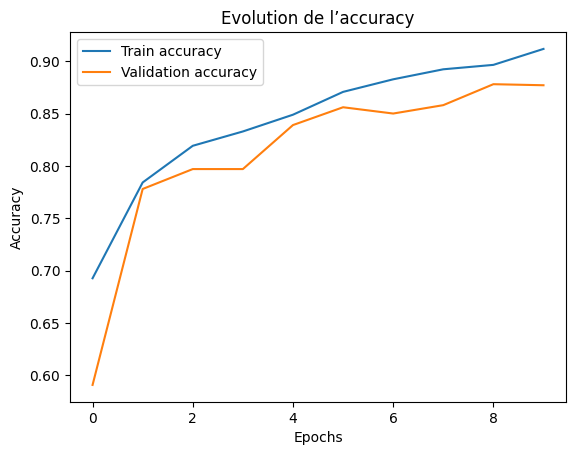

In [276]:
import matplotlib.pyplot as plt

#On affiche l'accuracy du modèle pendant l'entrainement et le test en fonction de chaque épochs
plt.figure()
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Evolution de l’accuracy')
plt.show()

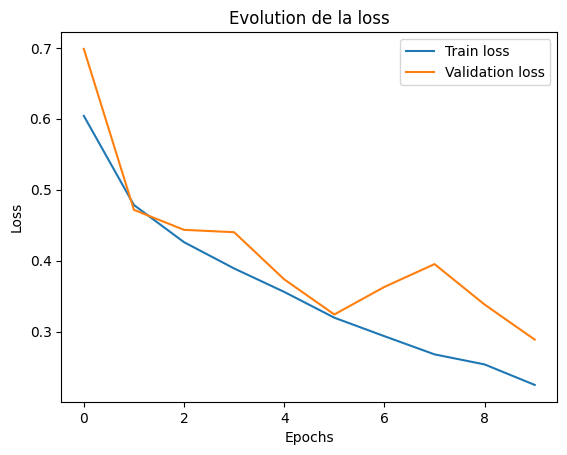

In [275]:
#On affiche la loss du modèle pendant l'entrainement et le test en fonction de chaque épochs
plt.figure()
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Evolution de la loss')
plt.show()